# Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create task environment

In [3]:
class environment:

    def __init__(self, rewards, transition_probability = 0.5):
        assert len(rewards) == 3 and len(rewards[0]) == 3 and len(rewards[1]) == 2 and len(rewards[2]) == 2
        self.rewards = rewards
        self.tp = transition_probability
        self.reset()
    
    def reset(self):
        self.u = 1
        self.actions = [0, 1, 2]
    
    def step(self, action):
        assert action in self.actions
        reward = self.rewards[self.u-1][action] # determine reward

        # determine if task is terminated or not
        if self.u == 1 and action == 1:
            terminated = False
            self.u = np.random.choice([2, 3], p=[self.tp, 1-self.tp])
            self.actions = [0, 1]
        else:
            terminated = True
            self.reset()
        
        return reward, terminated


In [4]:
# test the environment

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 100000
rewards = np.zeros(n_trials)
for trial in range(n_trials):
    terminated = False
    while not terminated:
        r, terminated = env.step(np.random.choice(env.actions))
        rewards[trial] += r

print(rewards.mean())

0.99016


# Policy Evaluation

#### Define agent class

In [5]:
class policy_eval_agent:

    def __init__(self, lr):
        self.lr = lr
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4) # make 4 entries: empty state 0 (for when trial is terminated) and states 1-3
    
    def eval_policy(self, u, u_prime, reward):
        delta = reward + self.v[u_prime] - self.v[u]
        self.v[u] += self.lr * delta
        return delta

#### Learn predictions

In [6]:
a = policy_eval_agent(0.2)

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 1000
repetitions = 1000
prediction_history = np.zeros((3, repetitions, n_trials+1))
for i in range(repetitions):
    for trial in range(n_trials):
        prediction_history[:,i,trial] = a.v[1:]
        terminated = False
        while not terminated:
            u = env.u
            reward, terminated = env.step(np.random.choice(env.actions))
            u_prime = env.u if not terminated else 0
            a.eval_policy(u, u_prime, reward)
    prediction_history[:,i,n_trials] = a.v[1:]
    a.reset()

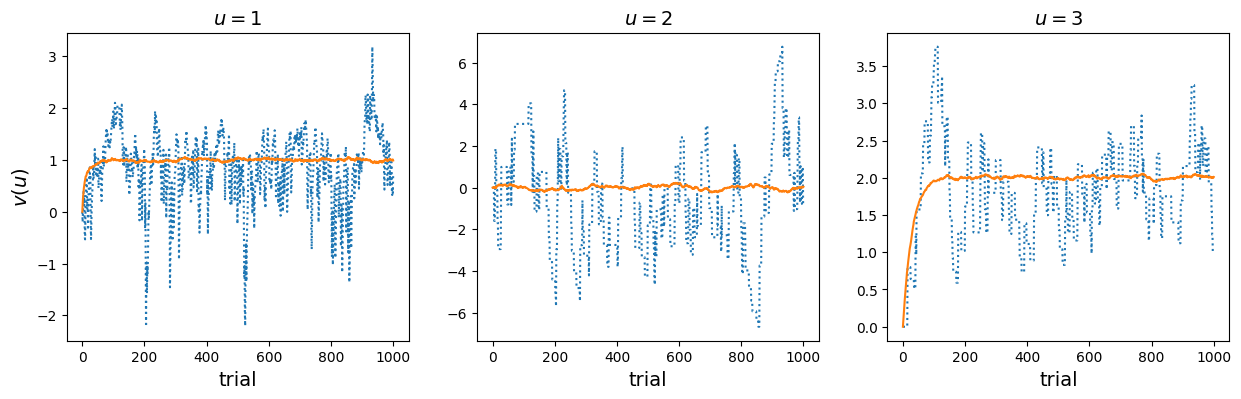

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for u in range(3):
    axs[u].set_title(f"$u = {u+1:d}$", fontsize=14)
    axs[u].plot(range(n_trials+1), prediction_history[u,0,:], ":")
    axs[u].plot(range(n_trials+1), prediction_history[u,:,:].mean(axis=0), "-")
    axs[u].set_xlabel("trial", fontsize=14)
axs[0].set_ylabel("$v(u)$", fontsize=14)
plt.show()


# Actor critic learning

In [8]:
class actor_critic_agent(policy_eval_agent):

    def __init__(self, lr, lr_a, beta):
        self.lr = lr
        self.lr_a = lr_a
        self.beta = beta
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4)
        self.m = {1: np.zeros(3), 2: np.zeros(2), 3: np.zeros(2)}
    
    def update_actor(self, u, u_prime, reward, action):
        delta = self.eval_policy(u, u_prime, reward)
        for i in range(len(self.m[u])):
            self.m[u][i] = (1 - self.lr) * self.m[u][i]
            self.m[u][i] += self.lr_a * delta if action == i else 0
    
    def choose_action(self, env):
        u = env.u
        mv = self.m[u]
        assert len(mv) == len(env.actions)
        pv = np.exp(self.beta*mv)
        pv /= pv.sum()
        action = np.random.choice(env.actions, p=pv)
        return action

In [9]:
a = actor_critic_agent(0.1, 0.075, 1)

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 1000
repetitions = 1000
prediction_history = np.zeros((3, repetitions, n_trials+1))
m_history = {1: np.zeros((3, repetitions, n_trials+1)), 2: np.zeros((2, repetitions, n_trials+1)), 3: np.zeros((2, repetitions, n_trials+1))}
for i in range(repetitions):
    for trial in range(n_trials):
        prediction_history[:,i,trial] = a.v[1:]
        for state in range(1,4):
            m_history[state][:,i,trial] = a.m[state].copy()
        terminated = False
        while not terminated:
            u = env.u
            action = a.choose_action(env)
            reward, terminated = env.step(action)
            u_prime = env.u if not terminated else 0
            a.update_actor(u, u_prime, reward, action)
    prediction_history[:,i,n_trials] = a.v[1:]
    for state in range(1,4):
        m_history[state][:,i,n_trials] = a.m[state].copy()
    a.reset()

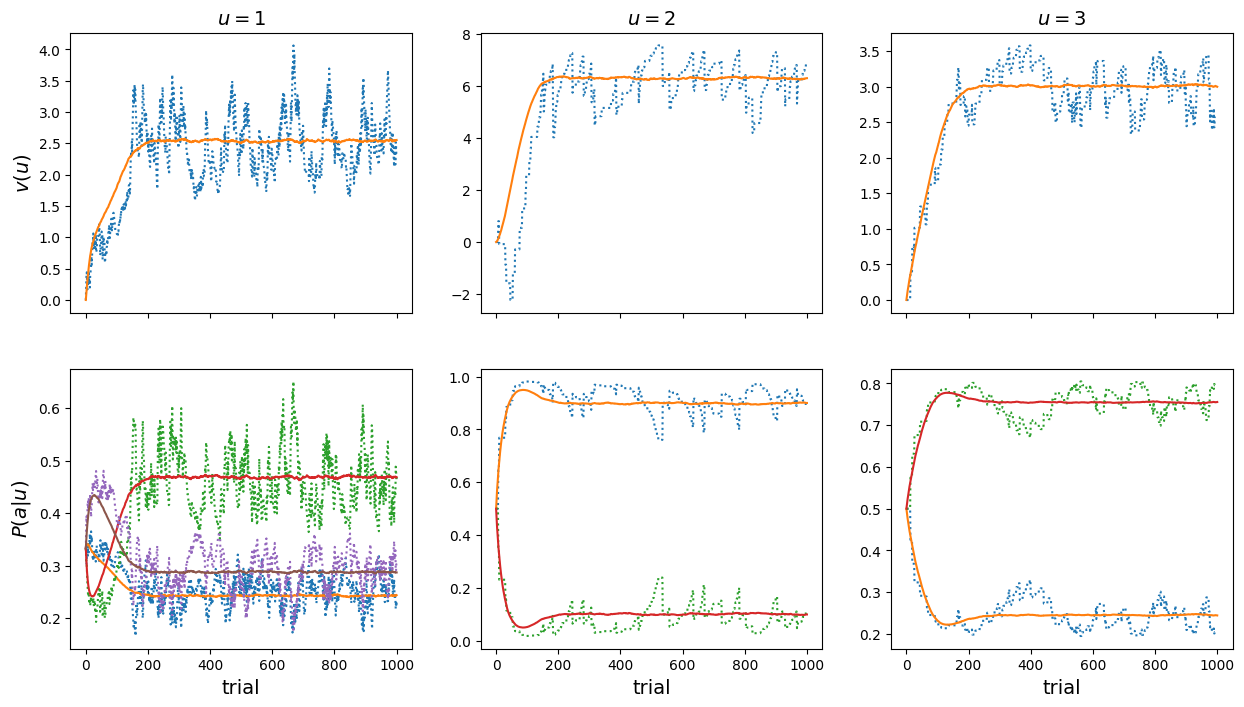

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)
for i in range(3):
    axs[0,i].set_title(f"$u = {i+1:d}$", fontsize=14)
    axs[0,i].plot(range(n_trials+1), prediction_history[i,0,:], ":")
    axs[0,i].plot(range(n_trials+1), prediction_history[i,:,:].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)
for i in range(3):
    mv = m_history[i+1]
    pv = np.exp(mv) / np.sum(np.exp(mv), axis=0)
    for j in range(pv.shape[0]):
        axs[1,i].plot(range(n_trials+1), pv[j,0,:], ":")
        axs[1,i].plot(range(n_trials+1), pv[j,:,:].mean(axis=0), "-")
        axs[1,i].set_xlabel("trial", fontsize=14)
        #axs[1,i].set_ylim(0,1)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()